# Character Classification
This notebook contains all steps of OCR

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Import Widgets
from ipywidgets import Button, Text, IntSlider, interact
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
from ocr.normalization import imageNorm, letterNorm
from ocr import page, words, charSeg
from ocr.helpers import implt, resize
from ocr.tfhelpers import Graph
from ocr.datahelpers import idx2char

%matplotlib inline

### Global Variables

In [28]:
# Settings
IMG = '2'    # 1, 2, 3
LANG = 'en'  # cz, en
MODEL_LOC = 'models/char-clas/' + LANG + '/CharClassifier'

## Load Trained Model

In [29]:
charClass = Graph(MODEL_LOC)

INFO:tensorflow:Restoring parameters from models/char-clas/en/CharClassifier


## Load image

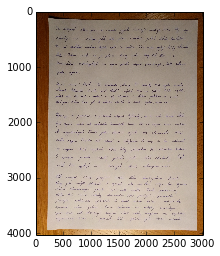

In [30]:
image = cv2.cvtColor(cv2.imread("test/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

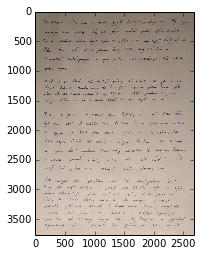

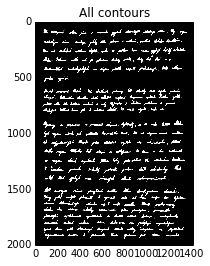

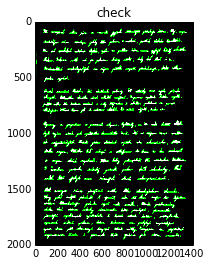

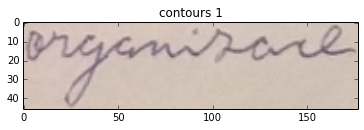

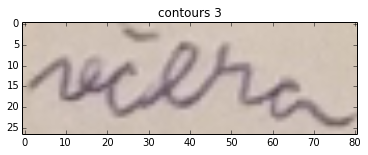

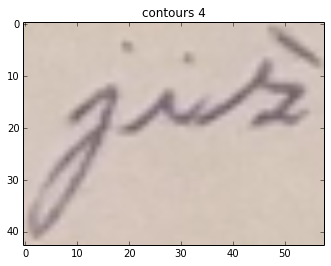

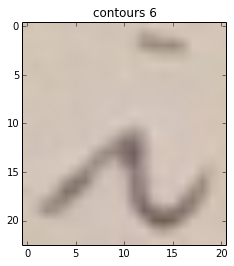

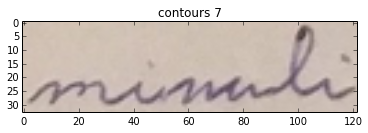

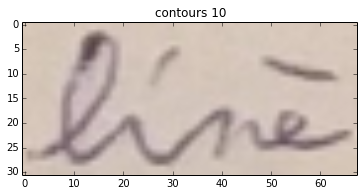

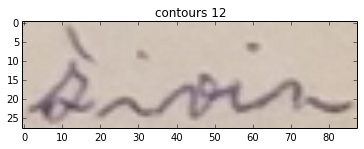

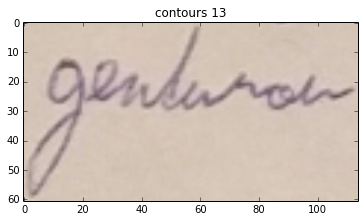

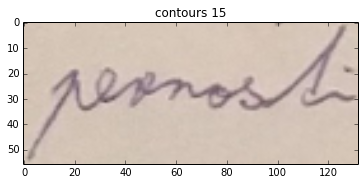

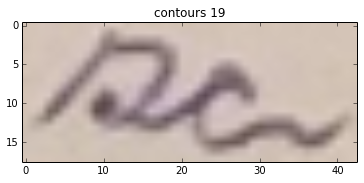

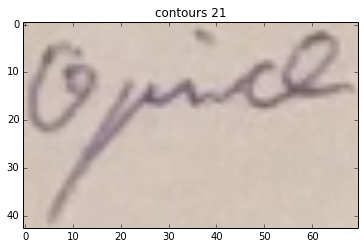

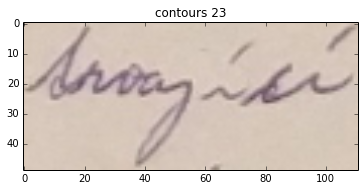

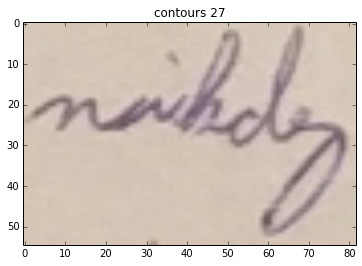

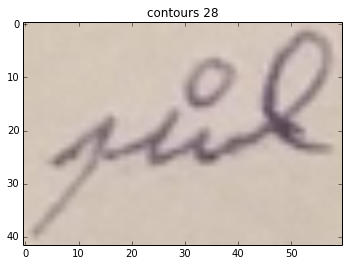

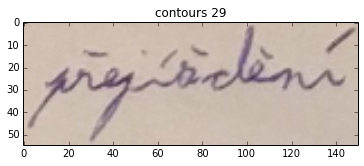

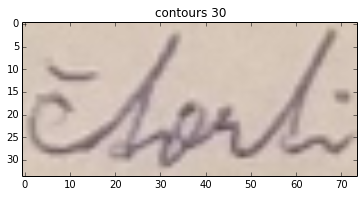

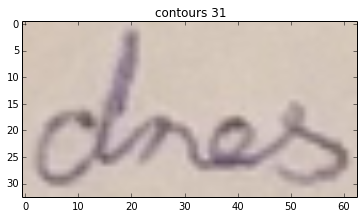

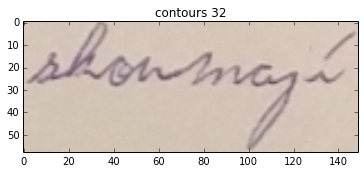

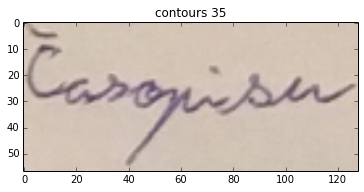

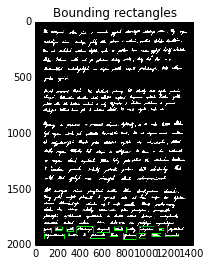

In [31]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

# Simple UI using widgets

In [14]:
class Cycler:
    """ Cycle through the words and recognise them """
    height = 60
    
    def __init__(self, image, boxes):
        self.boxes = boxes       # Array of bounding boxes
        self.image = resize(image,2000)       # Whole image
        
        
    def recognise(self, img):
        """ Recognising word and printing it """
        # Pre-processing the word
        img = imageNorm(img, 60, border=False, tilt=True, hystNorm=True)
            
        # Separate letters
        img = cv2.copyMakeBorder(img, 0, 0, 30, 30,cv2.BORDER_CONSTANT, value=[0, 0, 0])
        gaps = charSeg.segmentation(img, RNN=True, debug=True)
        
        chars = []
        for i in range(len(gaps)-1):
            char = img[:, gaps[i]:gaps[i+1]]
            # TODO None type error after treshold
            char, dim = letterNorm(char, is_thresh=True, dim=True)
            # TODO Test different values
            if dim[0] > 4 and dim[1] > 4:
                chars.append(char.flatten())
                
        chars = np.array(chars)
        word = ''        
        if len(chars) != 0:
            pred = charClass.run(chars)                
            for c in pred:
                word += idx2char(c)
                
        print("Word: " + word)

        
    def idxImage(self, index):
        """ Getting next image from the array """
        if index < len(self.boxes):
            b = self.boxes[index]
            print b.shape
            x1, y1, x2, y2 = b
            
            # Cuting out the word image
            img = self.image[y1:y2, x1:x2]            
            implt(img, t='Index: ' + str(index)) 
            
            self.recognise(img)

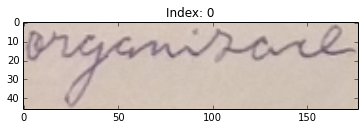

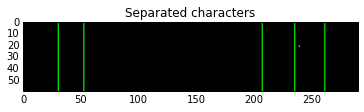

Word: eeei


<function ipywidgets.widgets.interaction.<lambda>>

In [32]:
cycler = Cycler(crop, bBoxes)

# Interactive slider
slider = IntSlider(
    value=0,
    min=0,
    max=len(bBoxes)-1,
    step=1,
    description='Index',
    continuous_update=False)

interact(
    cycler.idxImage,
    index = slider)

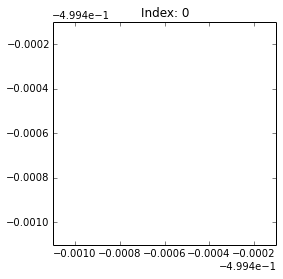

ZeroDivisionError: float division by zero

In [16]:
for i in range(len(bBoxes)):
    cycler.idxImage(i)